In [22]:
#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# Name: Jonah Zembower
# Date: March 11, 2025
# Project: EY Data Science Challenge 2025
#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

# Introduction:

The model was not accurate for the neural network to what we had hoped. There were better results seen in the random forest method while developing feature importance. That is what we go in depth here. 

# Libraries and Data:

Importing necessary libraries:

In [23]:
# Supress Warnings 
import warnings
warnings.filterwarnings('ignore')

# Import common libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# For the geodataframe
import geopandas as gpd
from shapely import wkt
from scipy.spatial import cKDTree

# Random forest libraries:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from scipy.spatial import cKDTree
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV

Importing datasets:

In [24]:
# Satellite Data:
all_bands_granular = pd.read_csv("C:\\Users\\jrzem\\OneDrive\\Desktop\\EY Dataset\\Satellite Data\\all_bands_granular.csv")
all_bands_noisy_proximity = pd.read_csv("C:\\Users\\jrzem\\OneDrive\\Desktop\\EY Dataset\\Satellite Data\\all_bands_noisy_proximity.csv")
all_bands_proximity_noisy = pd.read_csv("C:\\Users\\jrzem\\OneDrive\\Desktop\\EY Dataset\\Satellite Data\\all_bands_proximity_noisy.csv")
all_bands_proximity_rounded_3 = pd.read_csv("C:\\Users\\jrzem\\OneDrive\\Desktop\\EY Dataset\\Satellite Data\\all_bands_proximity_rounded_3.csv")
all_bands_proximity_rounded_3_mapped = pd.read_csv("C:\\Users\\jrzem\\OneDrive\\Desktop\\EY Dataset\\Satellite Data\\all_bands_proximity_rounded_3_mapped.csv")
indices_granular = pd.read_csv("C:\\Users\\jrzem\\OneDrive\\Desktop\\EY Dataset\\Satellite Data\\indices_granular.csv")
landsat_thermal_granular = pd.read_csv("C:\\Users\\jrzem\\OneDrive\\Desktop\\EY Dataset\\Satellite Data\\landsat_thermal_granular.csv")
noisy_long_lat_uhi = pd.read_csv("C:\\Users\\jrzem\\OneDrive\\Desktop\\EY Dataset\\Satellite Data\\noisy_long_lat_uhi.csv")

In [25]:
# Elevation Data:
all_elevation_nyc = pd.read_csv("C:\\Users\\jrzem\OneDrive\\Desktop\\EY Dataset\\Elevation\\all_elevation_nyc.csv")

In [26]:
# Load the test data
test_data = pd.read_csv("C:\\Users\\jrzem\\OneDrive\\Desktop\\EY Dataset\\Submission_template.csv")

# Random Forest Models:

1. sentinel (BO1, BO6 proximity) and elevation (building height only and natural elevation proximity)

### Model 1:

In [27]:
# Add the landsat_thermal_granular data to the all_bands_proximity_rounded_3_mapped data
all_bands_elevation_2 = all_bands_proximity_rounded_3_mapped.merge(all_elevation_nyc[['Longitude', 'Latitude', 'Building Height Only Proximity','Natural Proximity']], on=['Longitude', 'Latitude'])
all_bands_elevation_2

# Save to CSV
all_bands_elevation_2.to_csv("C:\\Users\\jrzem\\OneDrive\\Desktop\\EY Dataset\\Satellite Data\\all_bands_elevation_2.csv", index=False)

# Load dataset
all_bands_elevation_2 = pd.read_csv("C:\\Users\\jrzem\\OneDrive\\Desktop\\EY Dataset\\Satellite Data\\all_bands_elevation_2.csv")

In [28]:
# Load dataset
df = all_bands_elevation_2.copy()

# Define spectral features
spectral_features = ['BO1', 'BO6', 'Building Height Only Proximity','Natural Proximity']

# Select features and target
X = df[spectral_features]
y = df['UHI Index']

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardization (Not necessary for Random Forest but kept for consistency)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [29]:
# Initialize and train Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_scaled, y_train)

# Evaluate model performance
y_pred = rf_model.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Model Performance:\n - MAE: {mae:.4f}\n - RMSE: {rmse:.4f}")


Model Performance:
 - MAE: 0.0033
 - RMSE: 0.0047


In [30]:
# Define the parameter grid for hyperparameter tuning
param_dist = {
    'n_estimators': [100, 300, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize Random Forest Regressor
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

# Perform Randomized Search for hyperparameter tuning
random_search = RandomizedSearchCV(
    estimator=rf, param_distributions=param_dist,
    n_iter=10, cv=3, scoring='neg_mean_absolute_error',
    verbose=2, random_state=42, n_jobs=-1
)
random_search.fit(X_train_scaled, y_train)

# Get the best model from hyperparameter tuning
best_rf_model = random_search.best_estimator_

# Enable Out-of-Bag (OOB) Score for validation
best_rf_model.set_params(oob_score=True)
best_rf_model.fit(X_train_scaled, y_train)

# Evaluate model on the test set
y_pred = best_rf_model.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Print evaluation results
print(f"Optimized Model Performance:\n - MAE: {mae:.4f}\n - RMSE: {rmse:.4f}")
print(f"OOB Score: {best_rf_model.oob_score_}")


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Optimized Model Performance:
 - MAE: 0.0033
 - RMSE: 0.0047
OOB Score: 0.9183127402317672


The Hyperparameter tuning showcases the model is already performing well, and there is no need to update it. 

In [31]:
def add_nearest_data(uhi_data: pd.DataFrame, data_to_map: pd.DataFrame) -> pd.DataFrame:
    """
    Adds nearest spectral data to submission dataset using KDTree.

    Parameters:
        uhi_data (pd.DataFrame): DataFrame containing submission locations (Latitude, Longitude).
        data_to_map (pd.DataFrame): DataFrame containing spectral band values.

    Returns:
        pd.DataFrame: Submission dataset with matched spectral data.
    """
    # Extract coordinates
    elevation_coords = np.array(list(zip(data_to_map["Latitude"], data_to_map["Longitude"])))
    uhi_coords = np.array(list(zip(uhi_data["Latitude"], uhi_data["Longitude"])))
    
    # Build KDTree
    tree = cKDTree(elevation_coords)
    
    # Find nearest neighbors
    _, indices = tree.query(uhi_coords)
    
    # Add matched spectral data
    uhi_data = uhi_data.copy()
    for col in spectral_features:
        uhi_data[col] = data_to_map.iloc[indices][col].values
    
    return uhi_data

# Match spectral features for submission data
submission_all_bands_elevation = add_nearest_data(test_data, all_bands_elevation_2)


In [32]:
# Prepare submission data for prediction
x_submission_test = submission_all_bands_elevation[spectral_features]

# Standardize submission data using the same scaler
x_submission_test_scaled = scaler.transform(x_submission_test)

# Make predictions
submission_predictions = rf_model.predict(x_submission_test_scaled)

# Add predictions to submission DataFrame
submission_all_bands_elevation["UHI Index"] = submission_predictions

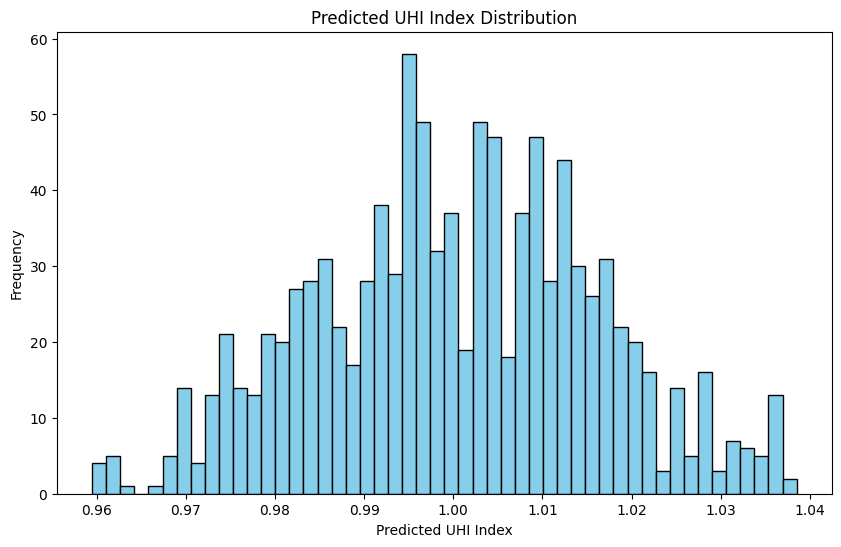

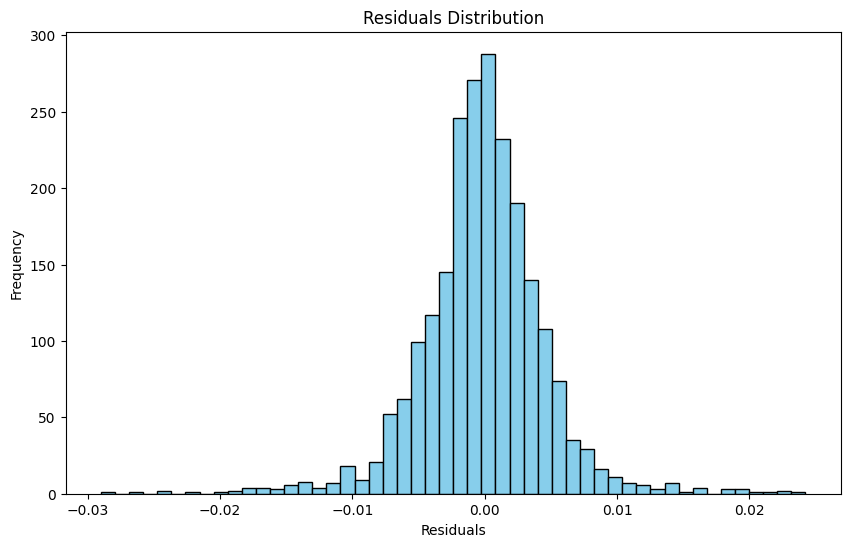

In [33]:
# Plot predictions
plt.figure(figsize=(10, 6))
plt.hist(submission_predictions, bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Predicted UHI Index')
plt.ylabel('Frequency')
plt.title('Predicted UHI Index Distribution')
plt.show()

# Plot Residuals
plt.figure(figsize=(10, 6))
plt.hist(y_test - y_pred, bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals Distribution')
plt.show()


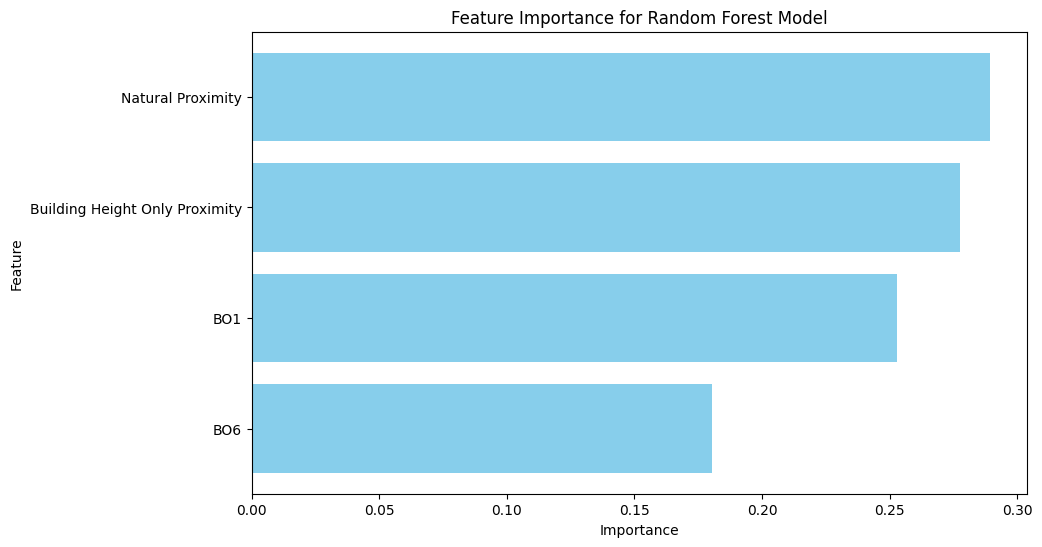

In [34]:
# Get feature importances
importances = rf_model.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': spectral_features,
    'Importance': importances
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for Random Forest Model')
plt.gca().invert_yaxis()
plt.show()

In [35]:
# Load the final submission
submission_all_bands_elevation_final = submission_all_bands_elevation[['Longitude', 'Latitude', 'UHI Index']]
submission_all_bands_elevation_final.to_csv("C:\\Users\\jrzem\\Downloads\\submission_all_bands_elevation.csv", index=False)

This model was 0.9243. This will be one of our best scores and best predicting models. We will look at some other factors as well soon.

### Model 2:

In [44]:
# Implementing Feature Engineering: Normalizing by Maximum Values with Random Forest
# Normalize data by maximum values (excluding the target variable 'UHI Index')
X_train_normalized = X_train / X_train.max()
X_test_normalized = X_test / X_train.max()  # Use training max to prevent data leakage

# Initialize the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=300, max_depth=20, 
                                 min_samples_split=5, min_samples_leaf=2, 
                                 bootstrap=True, max_samples=0.8, 
                                 oob_score=True, random_state=42, n_jobs=-1)

# Train the model
rf_model.fit(X_train_normalized, y_train)

# Predict on the test set
y_pred_rf = rf_model.predict(X_test_normalized)

# Evaluate model performance
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

# Print performance metrics
print(f"Random Forest Model with Max Normalization:\n - MAE: {mae_rf:.4f}\n - RMSE: {rmse_rf:.4f}")
print(f"OOB Score: {rf_model.oob_score_}")


Random Forest Model with Max Normalization:
 - MAE: 0.0035
 - RMSE: 0.0049
OOB Score: 0.9082305103308425


In [45]:
# Prepare submission data for prediction
x_submission_test = submission_all_bands_elevation[spectral_features]

# Standardize submission data using the same scaler
x_submission_test_scaled = scaler.transform(x_submission_test)

# Make predictions
submission_predictions = rf_model.predict(x_submission_test_scaled)

# Add predictions to submission DataFrame
submission_all_bands_elevation["UHI Index"] = submission_predictions

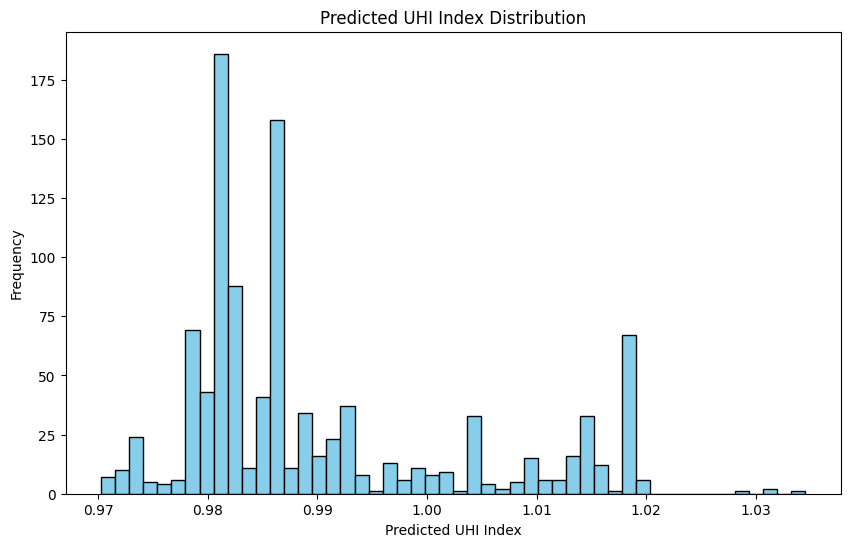

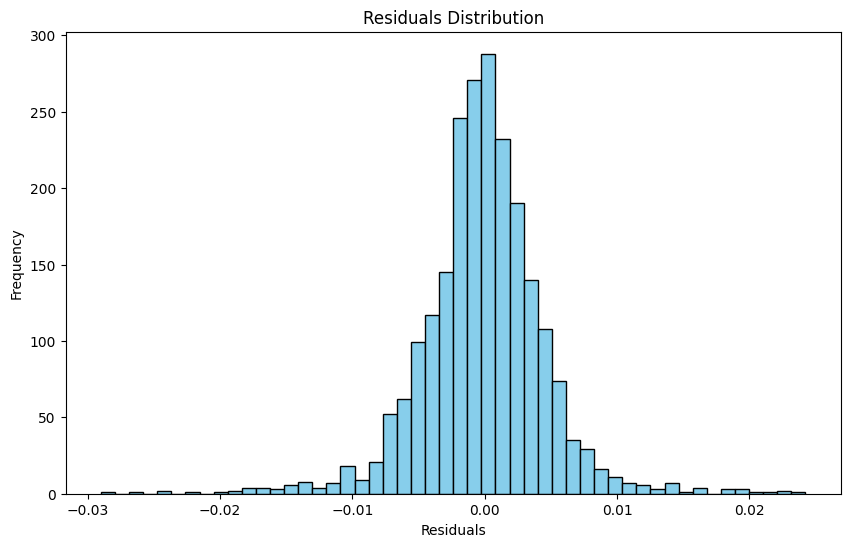

In [46]:
# Plot predictions
plt.figure(figsize=(10, 6))
plt.hist(submission_predictions, bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Predicted UHI Index')
plt.ylabel('Frequency')
plt.title('Predicted UHI Index Distribution')
plt.show()

# Plot Residuals
plt.figure(figsize=(10, 6))
plt.hist(y_test - y_pred, bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals Distribution')
plt.show()

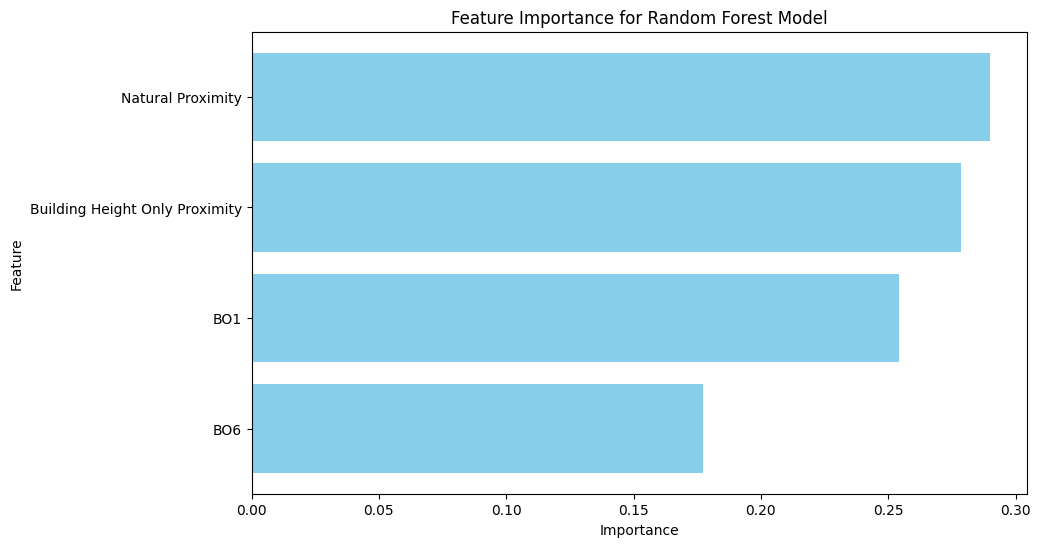

In [42]:
# Get feature importances
importances = rf_model.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': spectral_features,
    'Importance': importances
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for Random Forest Model')
plt.gca().invert_yaxis()
plt.show()

In [47]:
# Load the final submission
submission_all_bands_elevation_final = submission_all_bands_elevation[['Longitude', 'Latitude', 'UHI Index']]
submission_all_bands_elevation_final.to_csv("C:\\Users\\jrzem\\Downloads\\submission_all_bands_elevation.csv", index=False)

This didn't perform as well as we would hope. The standard scaling method is most appropriate.

# Conclusion: